## Импорты и чтение данных

In [2]:
# отключение ворнингов
import warnings
warnings.filterwarnings('ignore')

# импортирую библиотеки
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
import seaborn as sns

# настройки отображения строк и столбцов в пандас
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

# настройка размеров графиков
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 8)

# настройка стиля графиков
plt.style.use('fivethirtyeight')

Populating the interactive namespace from numpy and matplotlib


In [3]:
# чтение данных

df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
# выведу долю пропусков по столбцам

def missing_values(data):
    """
    Возвращает только колонки с пропусками:
    - общее число пропущенных значений
    - доля пропусков
    """
    missing = pd.DataFrame(df.isnull().sum())
    missing['% of Total Values'] = 100 * df.isnull().sum() / len(df)
    missing.rename(columns = {0 : 'Missing Values'}, inplace=True)
    missing.sort_values(by='% of Total Values', ascending=False, inplace=True)
    missing = missing[missing['Missing Values']>0]
    
    return missing

missing_values(df)

,Missing Values,% of Total Values


Пропусков нет, можно приступать к анализу.

## Визуальный анализ данных  

### Целевая переменная

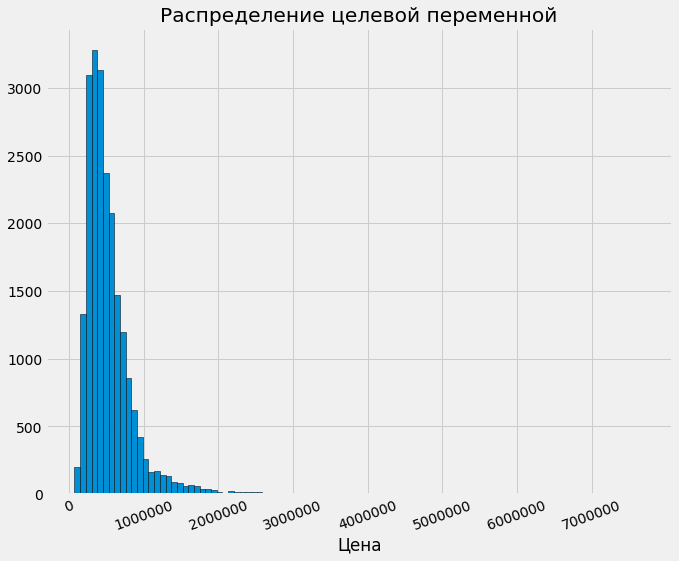

In [5]:
# оценю распределение целевой переменной

plt.hist(df['price'], bins=100, edgecolor='k')
plt.xlabel('Цена')
plt.xticks(np.arange(0, int(max(df['price'])), 1000000), rotation = 20)
plt.title('Распределение целевой переменной');

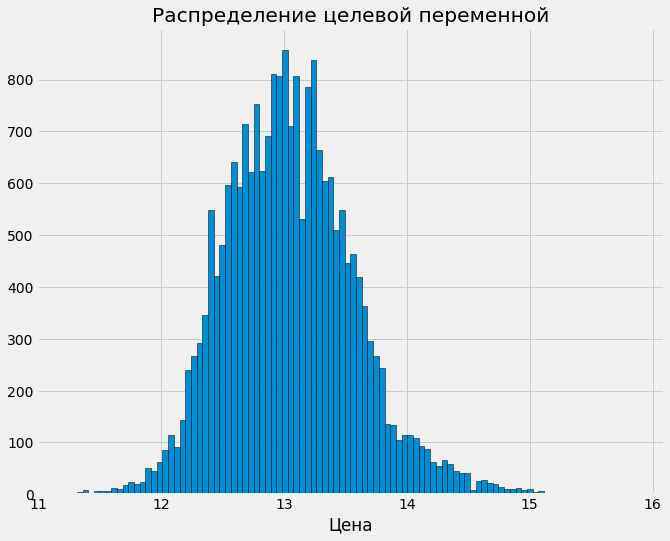

In [6]:
# а что если прологарифмировать?

plt.hist(np.log(df['price']), bins=100, edgecolor='k')
plt.xlabel('Цена')
plt.title('Распределение целевой переменной');

Так уже больше похоже на нормальное распределение.

P significance level is 0.98919
P-value is 0.00000


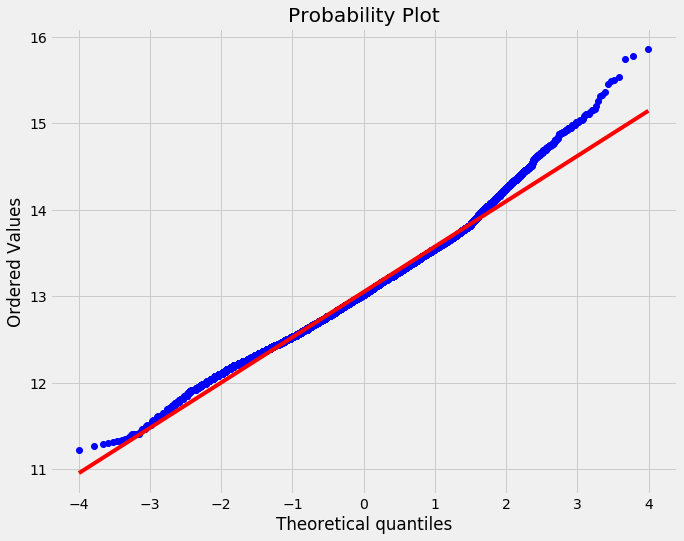

In [7]:
# добавлю логарифм цены и буду использоватьв качестве целового признака
df['log_price'] = np.log(df['price'])

# проверю на нормальность и построю qq plot
p_sign, p_value = stats.shapiro(df['log_price'])
print('P significance level is %.5f' %(p_sign))
print('P-value is %.5f' %(p_value))

stats.probplot(df['log_price'], dist="norm", plot=plt)
plt.show();

Прологарифмированная цена на недвижимоть действительно очень близка к нормальному распределению.  

### Анализ признаков

In [8]:
def feature_stat(data, feature, target):
    """
    Выводит гистограмму и среднее значение целевой
    по группе.
    Подходит для категориальных переменных
    """
    x = [i for i in data.groupby(feature)[target].count().index]
    
    y_cnt = [i for i in data.groupby(feature)[target].count().values]
    y_mean = [i for i in data.groupby(feature)[target].mean().values]
    ind = np.arange(len(data[feature].unique()))
    
    fig, ax1 = plt.subplots()
    ax1.bar(ind, y_cnt, align='center', edgecolor='k', width=0.4, alpha=0.7)
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Counts', color='b')
    ax1.tick_params('y', colors='b')
    ax2 = ax1.twinx()
    ax2.plot(ind, y_mean, 'r')
    ax2.set_ylabel('Target mean rate', color='r')
    ax2.tick_params('y', colors='r')
    plt.xticks(ind, x, rotation=45)
    plt.title('{} and target'.format(feature))
    ax1.set_xticklabels(x, rotation=35)
    plt.grid(False)
    plt.show()

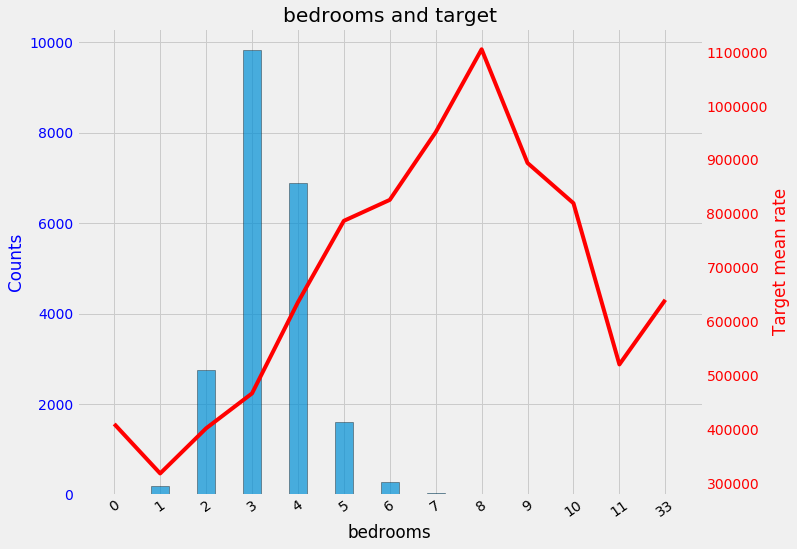

In [9]:
# начну со спален

feature_stat(df, 'bedrooms', 'price')

Объединю в одну группу все объекты с кол-вом спален больше 6, приравняв их к 6.  
Кроме того, подозрительно выглядит то, что объекты без спален (видимо, студии) дороже объектов с 1 спальней.

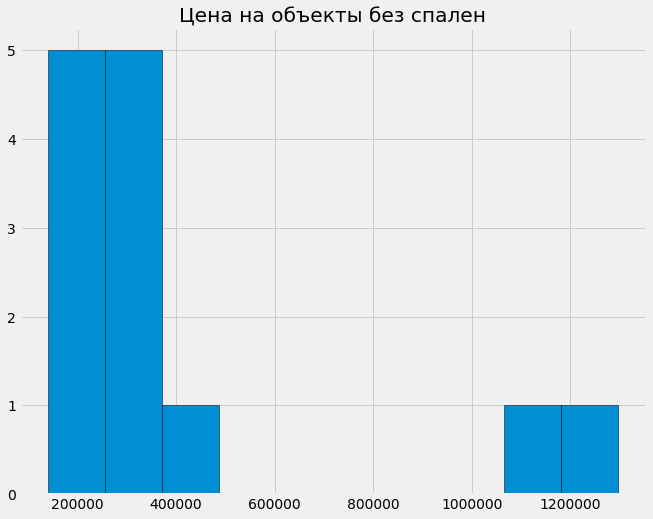

In [10]:
plt.hist(df[df['bedrooms'] == 0]['price'], bins = 10, edgecolor='k')
plt.title('Цена на объекты без спален');

Ага, есть объекты без спален сильно дороже остальных. Посмотрю на них:

In [11]:
df[(df['bedrooms'] == 0) & (df['price']>1000000)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
875,6306400140,20140612T000000,1095000.0,0,0.0,3064,4764,3.5,0,2,3,7,3064,0,1990,0,98102,47.6362,-122.322,2360,4000,13.906265
6994,2954400190,20140624T000000,1295650.0,0,0.0,4810,28008,2.0,0,0,3,12,4810,0,1990,0,98053,47.6642,-122.069,4740,35061,14.074523


Пока оставлю все как есть. В будущем, возможно, вернусь к этому моменту.

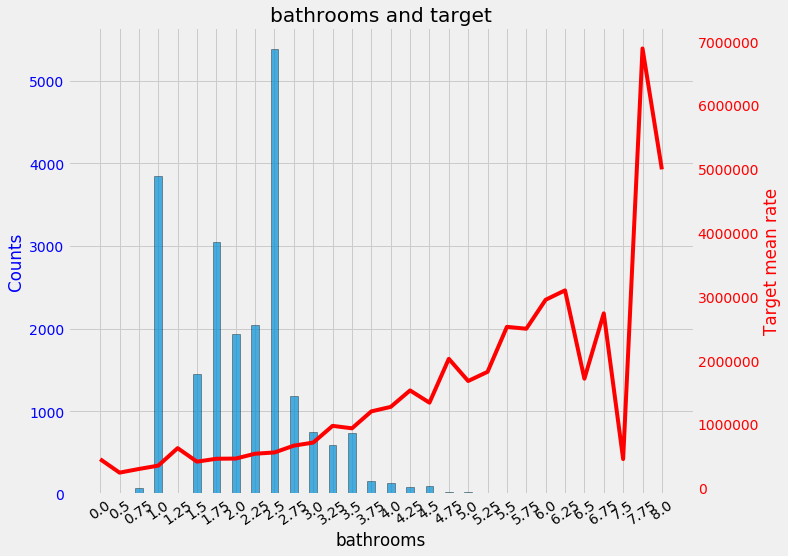

In [12]:
# посмотрим на ванные комнаты и цену

feature_stat(df, 'bathrooms', 'price')

Не совсем понятно, что такое четверть ванной, но все, что больше 3.5, кажется, стоит так же объединить в одну группу.

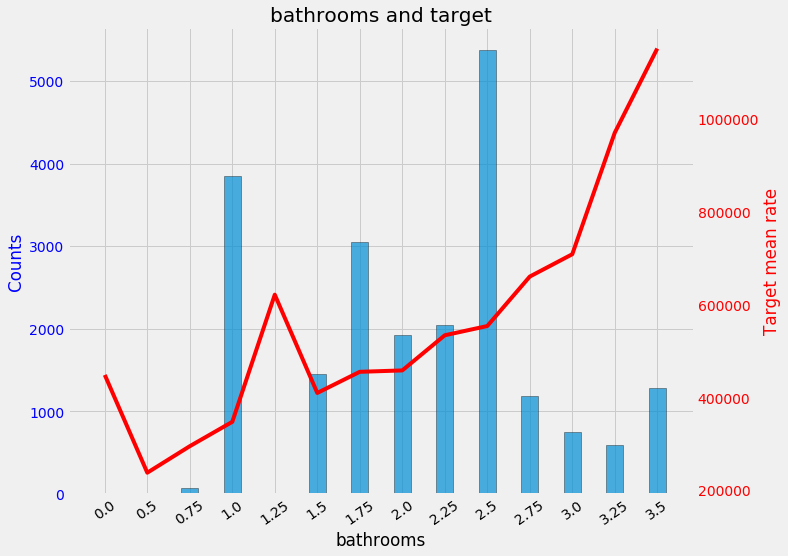

In [13]:
df.loc[df['bathrooms']>3.5, 'bathrooms'] = 3.5

feature_stat(df, 'bathrooms', 'price')

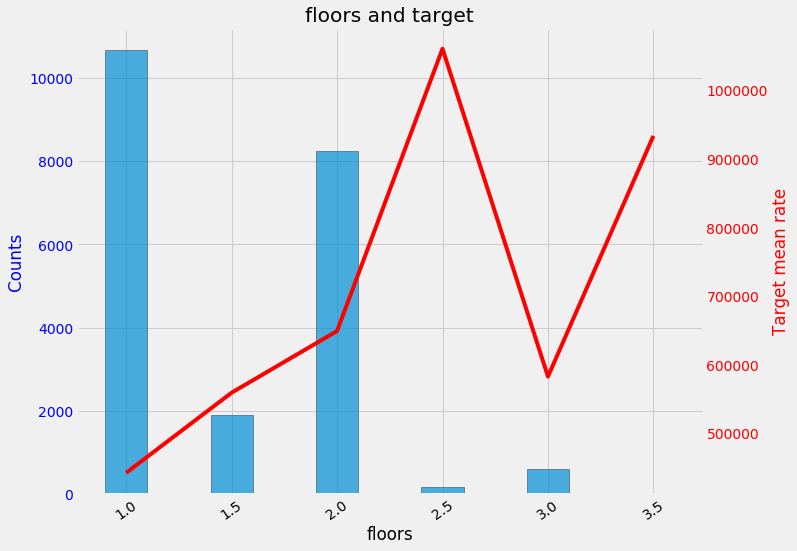

In [14]:
# кол-во этажей

feature_stat(df, 'floors', 'price')

Объединю всех, у кого больше 2 этажей в одну группу:

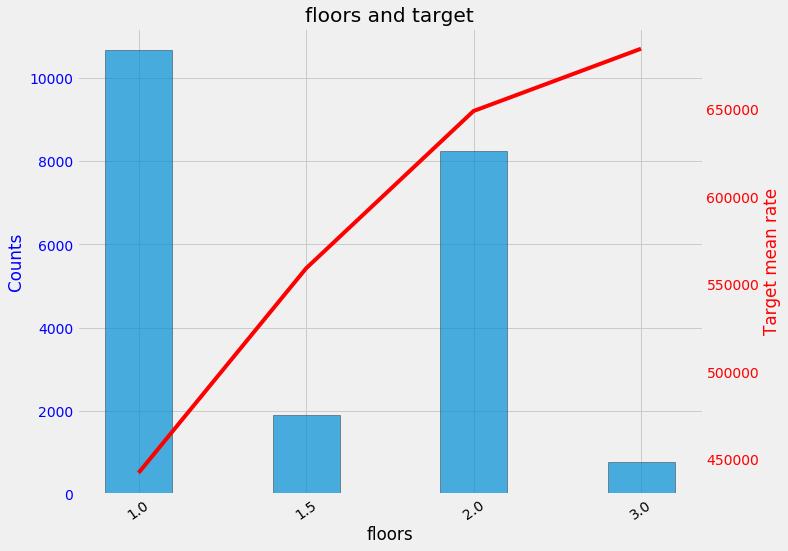

In [15]:
df.loc[df['floors'] > 2, 'floors'] = 3

feature_stat(df, 'floors', 'price')

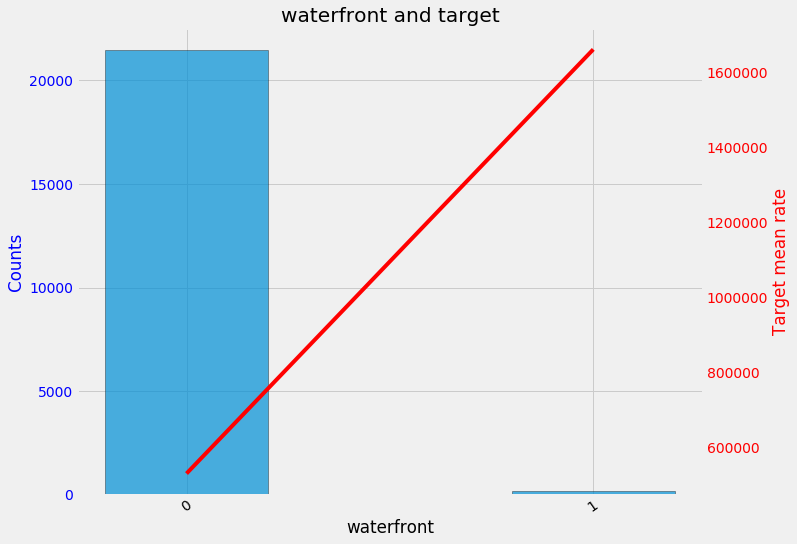

In [16]:
# вид на водоём

feature_stat(df, 'waterfront', 'price')

Тут все логично и понятно - недвижимость у воды дороже.

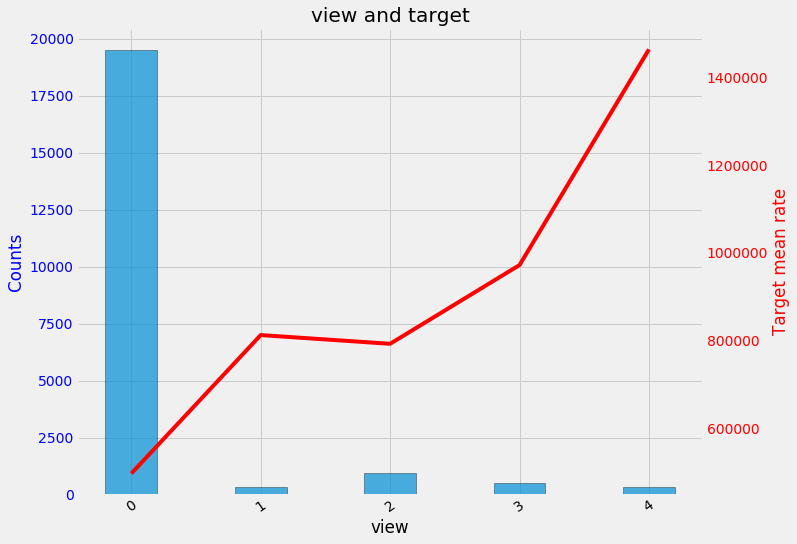

In [17]:
# вид (вероятно, субъективная оценка)

feature_stat(df, 'view', 'price')

Довольно странная переменная, с сильным дисбалансом. Пока оставлю как есть.

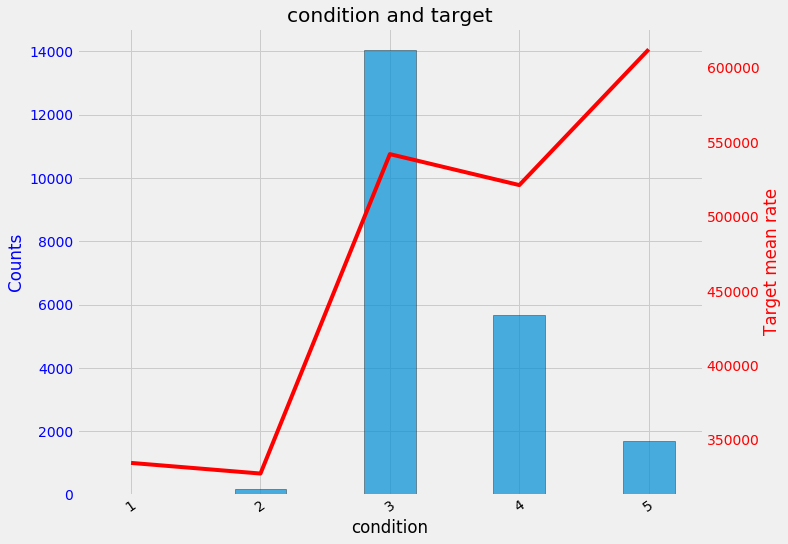

In [18]:
# состояние

feature_stat(df, 'condition', 'price')

Странным кажется то, что объекты в состоянии 4 в среднем дешевле объектов в состоянии 3.   
1 и 2 небольшие и близки друг другу по средней цене, объединю их в одну группу.

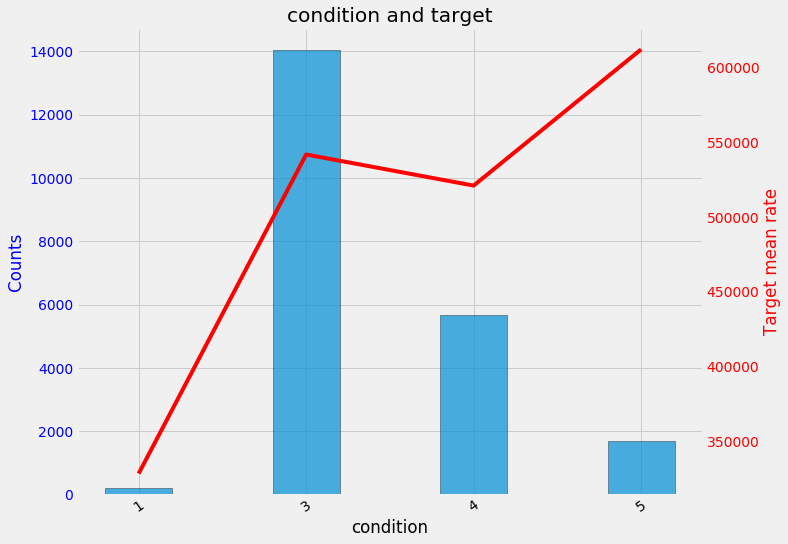

In [19]:
df.loc[df['condition'] == 2, 'condition'] = 1

feature_stat(df, 'condition', 'price')

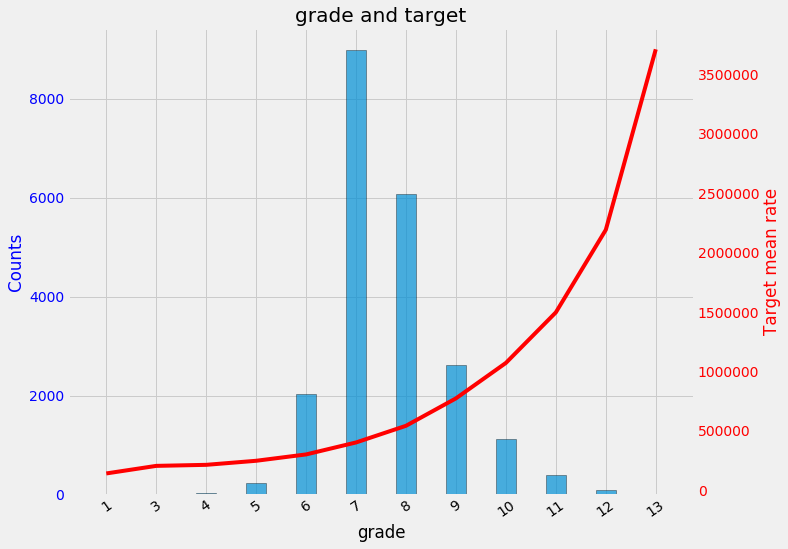

In [20]:
# грейд, класс объекта по местной системе классификации

feature_stat(df, 'grade', 'price')

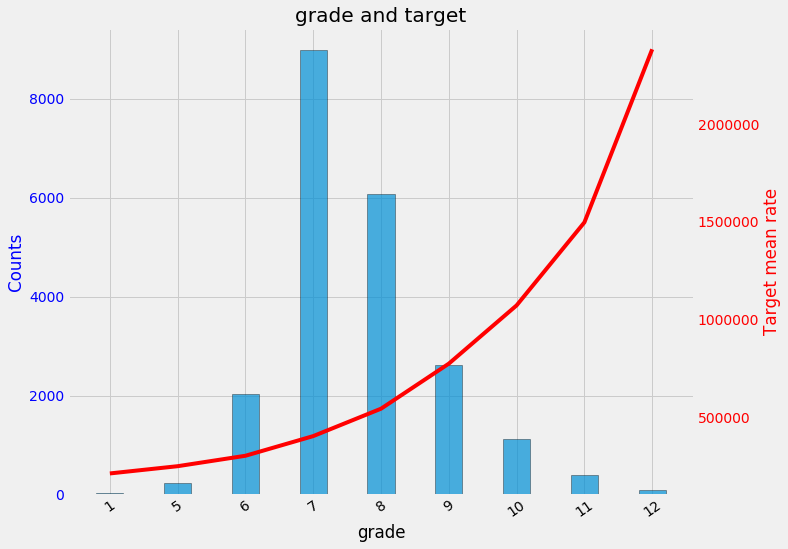

In [21]:
# объединю "небольшие" грейды

df.loc[df['grade'] < 5, 'grade'] = 1
df.loc[df['grade'] > 12, 'grade'] = 12

feature_stat(df, 'grade', 'price')

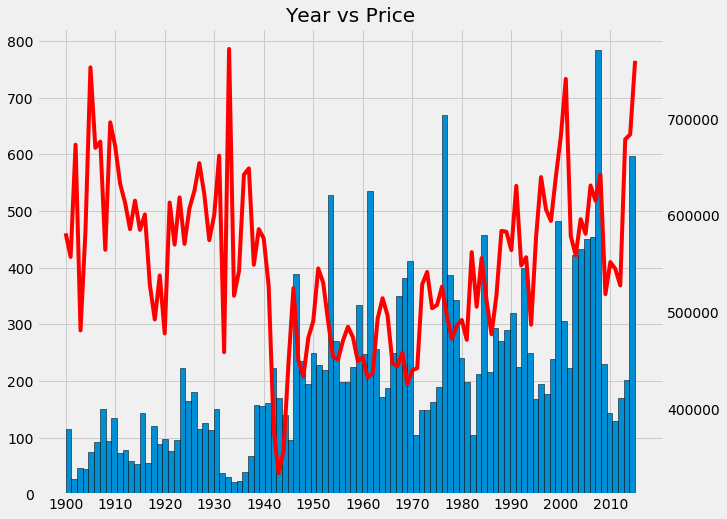

In [22]:
# год постройки

fig, ax1 = plt.subplots()

ax1.hist(df['yr_built'],  edgecolor='k', bins = 100)
ax2 = ax1.twinx()

ax2.plot(df.groupby('yr_built')['price'].mean(), color='r')
plt.xticks(np.arange(1900, 2020, 10), rotation=15)
plt.grid(False)
plt.title('Year vs Price');

Интересный момент, здания до 40-х годов сопоставимы по цене с самыми новыми, а сильный спад в ценах приходится на 40-е, далее цена растет по мере новизны здания. Возможно, стоит объединить здания по декадам.

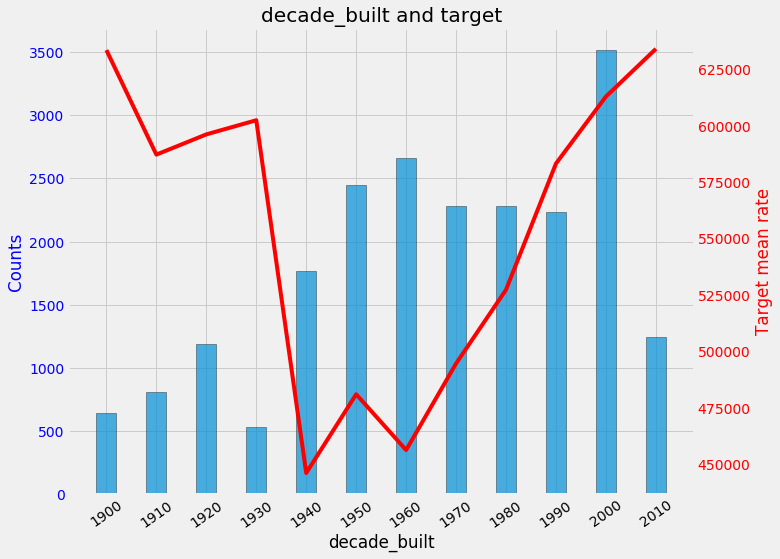

In [23]:
# декада постройки

df['decade_built'] = df['yr_built'].apply(lambda x: x//10*10)

feature_stat(df, 'decade_built', 'price');

Оставлю пока оба признака, но, полагаю, что один из них придется убрать.

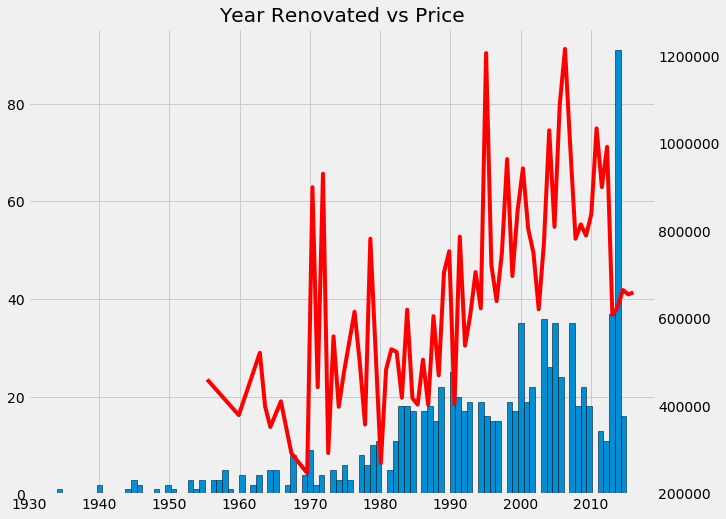

In [24]:
# год реновации

fig, ax1 = plt.subplots()

ax1.hist(df[df['yr_renovated']>0]['yr_renovated'],  edgecolor='k', bins = 100)
ax2 = ax1.twinx()

ax2.plot(df[df['yr_renovated']>0].groupby('yr_renovated')['price'].mean(), color='r')
plt.xticks(np.arange(1900, 2020, 10), rotation=15)
plt.grid(False)
plt.title('Year Renovated vs Price');

In [25]:
df.groupby('yr_renovated')['price'].agg(['count', 'mean']).sort_values(by='count', ascending=False).head(10)

,count,mean
yr_renovated,,
0,20699,530360.818155
2014,91,654756.252747
2013,37,664663.513514
2003,36,991444.444444
2007,35,838493.571429
2005,35,814818.285714
2000,35,809098.571429
2004,26,781866.923077
1990,25,748861.200000


Интересна довольно низкая цена на отреставрированные объекты в 2013 и 2014. Но тк в сравнении с размером датасета их не так много, опущу этот момент.

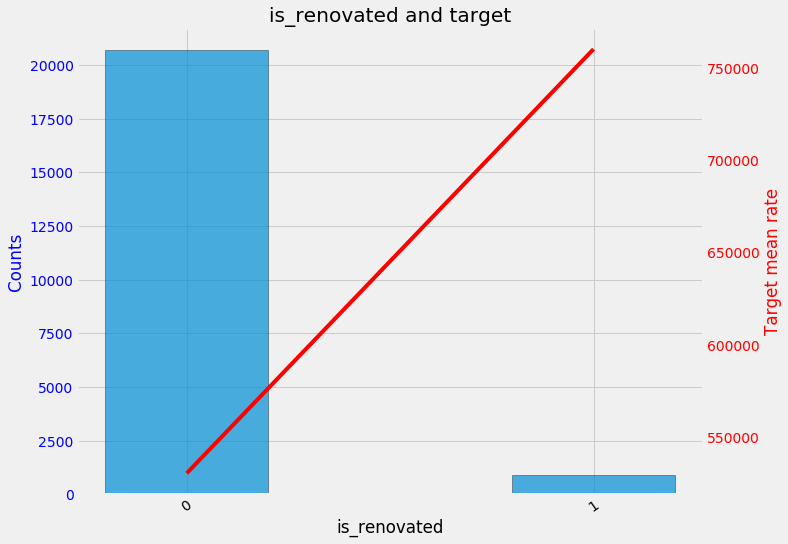

In [26]:
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)

feature_stat(df, 'is_renovated', 'price')

Интересно. Большая часть домов не реставрировались, но те, что реставрировались, в среднем дороже.  

Интересно, если ли зависимость между тем, как много прошло с момента постройки до реновации.

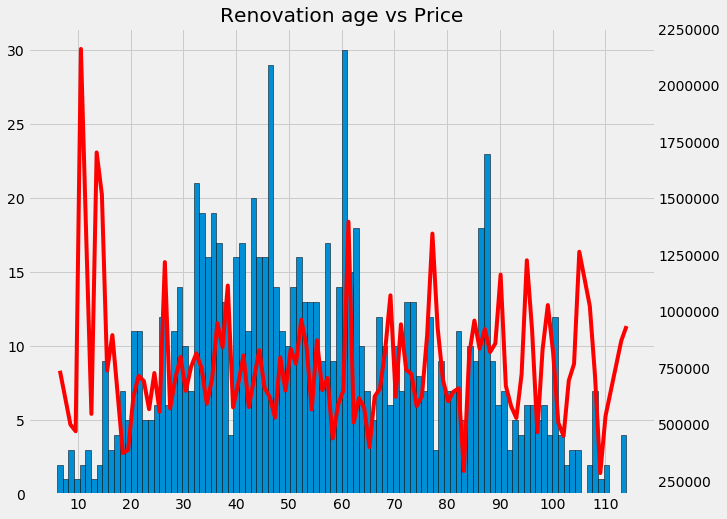

In [27]:
df['renovation_diff'] = df['yr_renovated'] - df['yr_built']

fig, ax1 = plt.subplots()

ax1.hist(df[df['renovation_diff']>0]['renovation_diff'],  edgecolor='k', bins = 100)
ax2 = ax1.twinx()

ax2.plot(df[df['renovation_diff']>0].groupby('renovation_diff')['price'].mean(), color='r')
plt.xticks(np.arange(0, 120, 10), rotation=15)
plt.grid(False)
plt.title('Renovation age vs Price');

Тут особых выводов сделать не получается.

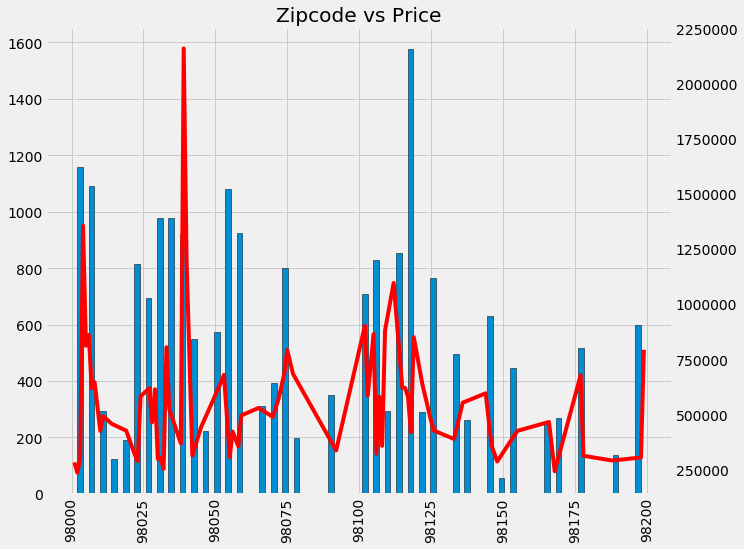

In [28]:
# почтовый индекс

fig, ax1 = plt.subplots()

ax1.hist(df['zipcode'],  edgecolor='k', bins = 50, rwidth=0.5)
plt.xticks(rotation=90)
ax2 = ax1.twinx()

ax2.plot(df.groupby('zipcode')['price'].mean(), color='r')
plt.grid(False)
plt.title('Zipcode vs Price');

Так совсем ненаглядно, попробую построить боксплоты:

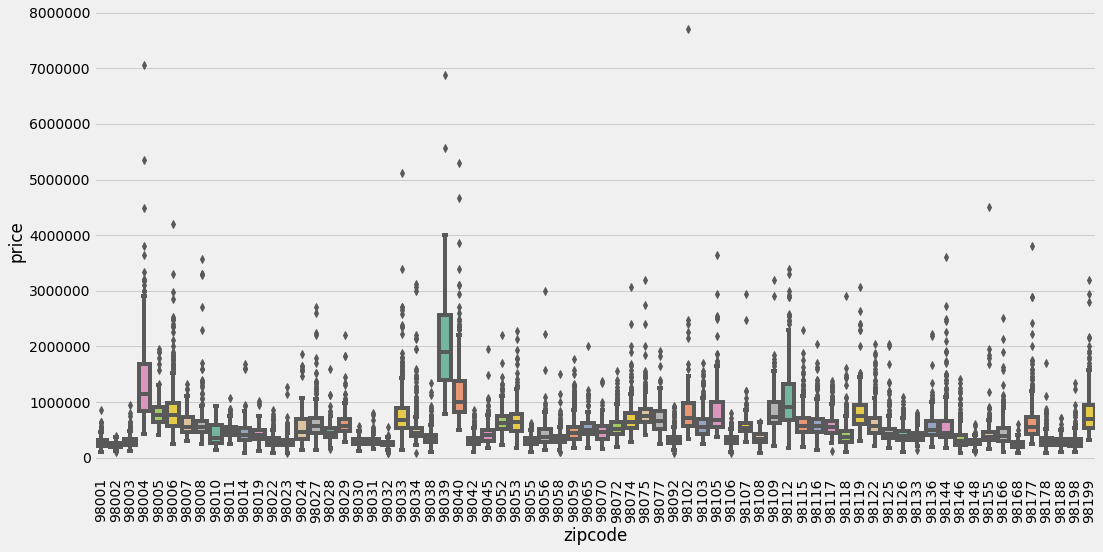

In [29]:
plt.figure(figsize=(16,8))
sns.boxplot(x='zipcode', y='price', data=df, palette='Set2')
plt.xticks(rotation=90);

Видим, что есть очевидно выделяющиеся индексы с дорогой недвижимостью. Выделим их в отдельный признак.

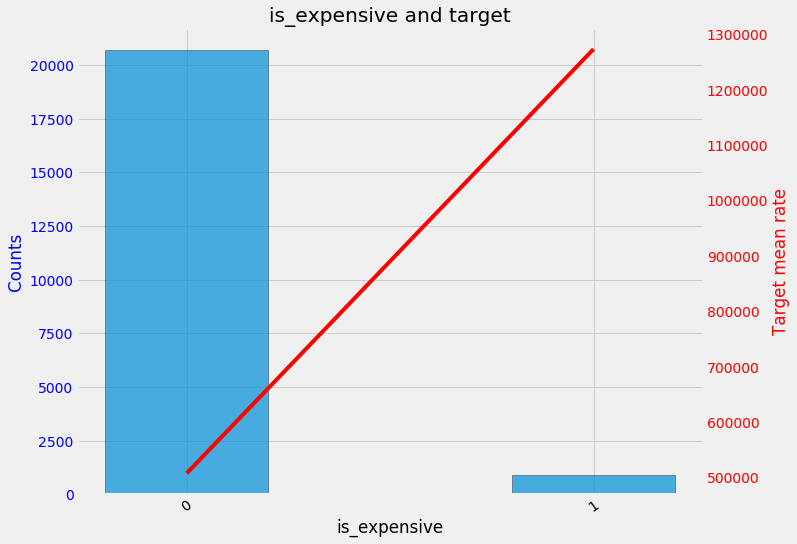

In [30]:
zipcodes = df.groupby('zipcode')[['price']].agg(np.mean).reset_index()
expensive = zipcodes[zipcodes['price']>1000000]['zipcode'].values

df['is_expensive'] = df['zipcode'].apply(lambda x: 1 if x in expensive else 0)

feature_stat(df, 'is_expensive', 'price')

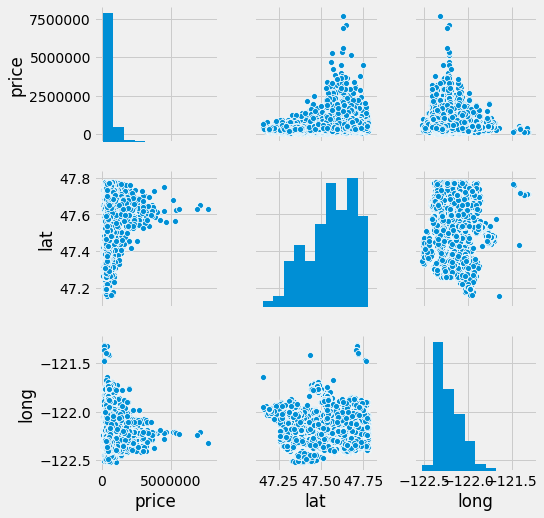

In [31]:
# теперь оценю зависимость цены от широты и долготы

sns.pairplot(df[['price','lat', 'long']]);

Попробую посмотреть поближе.

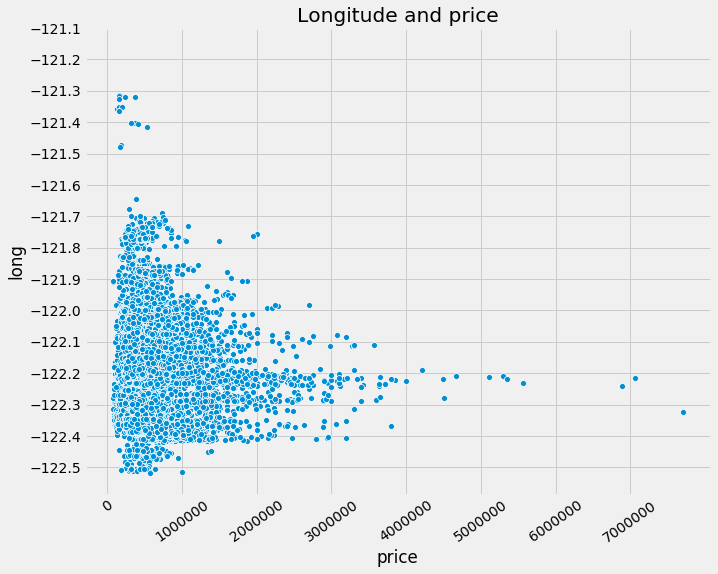

In [32]:
sns.scatterplot(df['price'], df['long'])

plt.title('Longitude and price')
plt.yticks(np.arange(-122.5, -121, .1))
plt.xticks(np.arange(0, 8000000, 1000000), rotation=35);

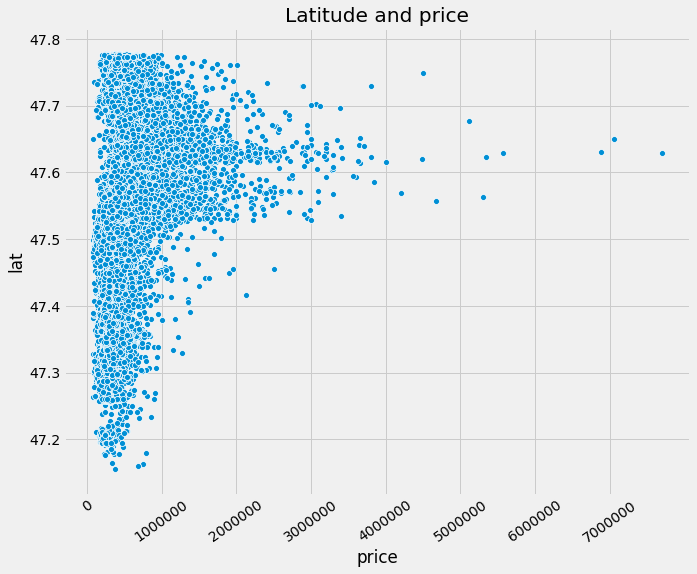

In [33]:
sns.scatterplot(df['price'], df['lat'])

plt.title('Latitude and price')
plt.xticks(np.arange(0, 8000000, 1000000), rotation=35);

Особых инсайтов найти не удалось, оставлю как есть.

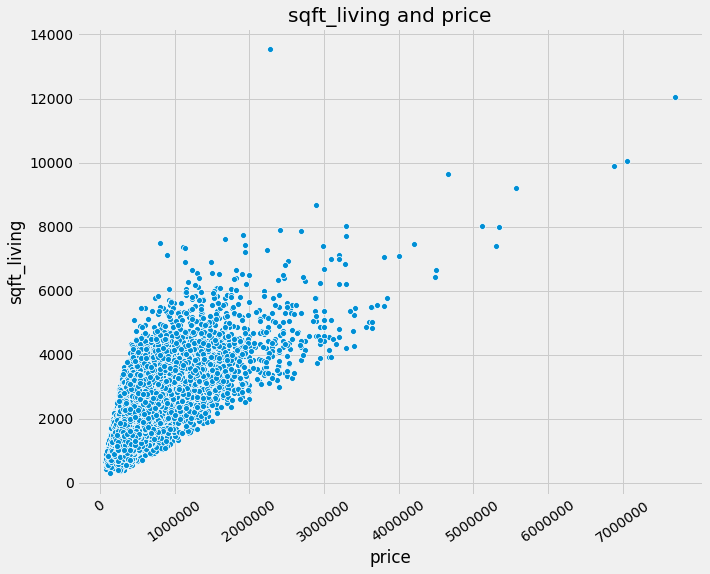

In [34]:
sns.scatterplot(df['price'], df['sqft_living'])

plt.title('sqft_living and price')
plt.xticks(np.arange(0, 8000000, 1000000), rotation=35);

Визуально заметна логичная зависимость - чем больше объект, тем он дороже.  
Посмотрю на корреляцию:

In [35]:
print('sqft living vs price correlation is {}'.format(df['sqft_living'].corr(df['price'])))

sqft living vs price correlation is 0.7020350546118002


Довольно высокий коэффициент, что ожидаемо. Стоит отметить, что чем больше объект, тем выше дисперсия цен на него, что тоже логично.

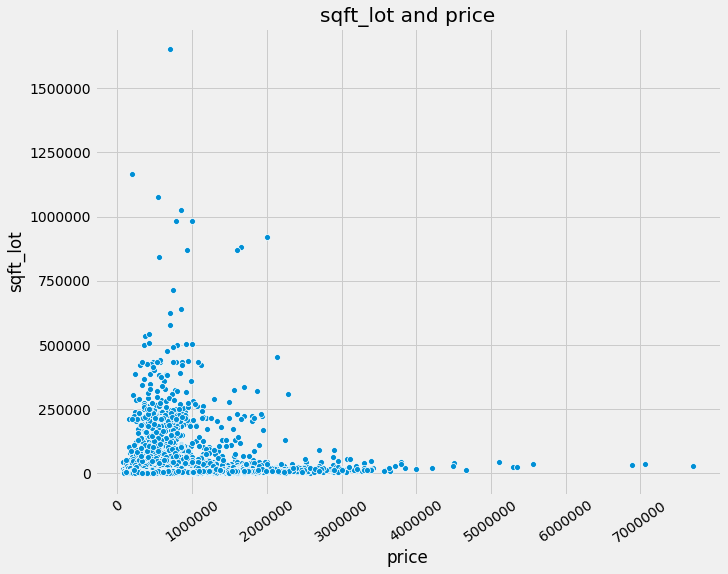

In [36]:
sns.scatterplot(df['price'], df['sqft_lot'])

plt.title('sqft_lot and price')
plt.xticks(np.arange(0, 8000000, 1000000), rotation=35);

Интересно, что с площадью участка такой сильной зависимости нет:

In [37]:
print('sqft living vs price correlation is {}'.format(df['sqft_lot'].corr(df['price'])))

sqft living vs price correlation is 0.08966086058710017


In [38]:
# проверю корреляцию между площадью дома и участка

print('sqft living vs sqft_lot correlation is {}'.format(df['sqft_living'].corr(df['sqft_lot'])))

sqft living vs sqft_lot correlation is 0.17282566132360033


Видно, что в King County правило строить большой дом на большом участке не всегда работает :)

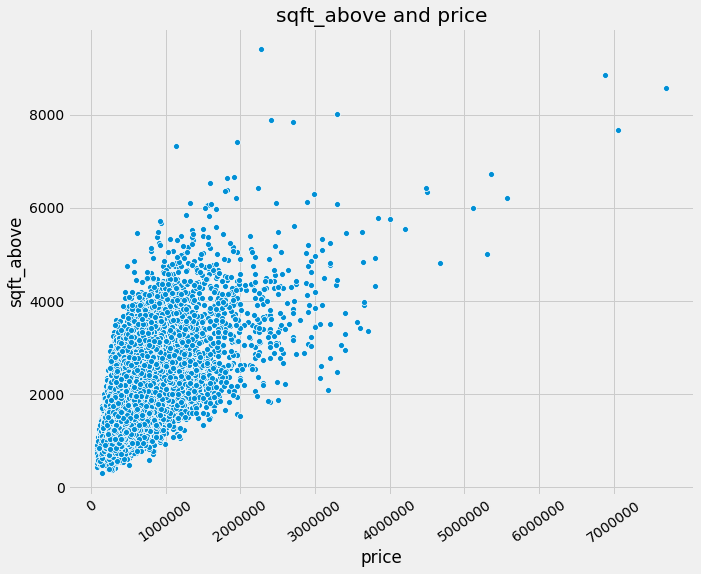

In [39]:
# посмотрю на другие признаки с площадью

sns.scatterplot(df['price'], df['sqft_above'])

plt.title('sqft_above and price')
plt.xticks(np.arange(0, 8000000, 1000000), rotation=35);

In [40]:
# проверю корреляцию между площадью дома (без учета подвала) и ценой

print('sqft above vs price correlation is {}'.format(df['sqft_above'].corr(df['price'])))

sqft above vs price correlation is 0.6055672983560781


Корелляция так же заметная.

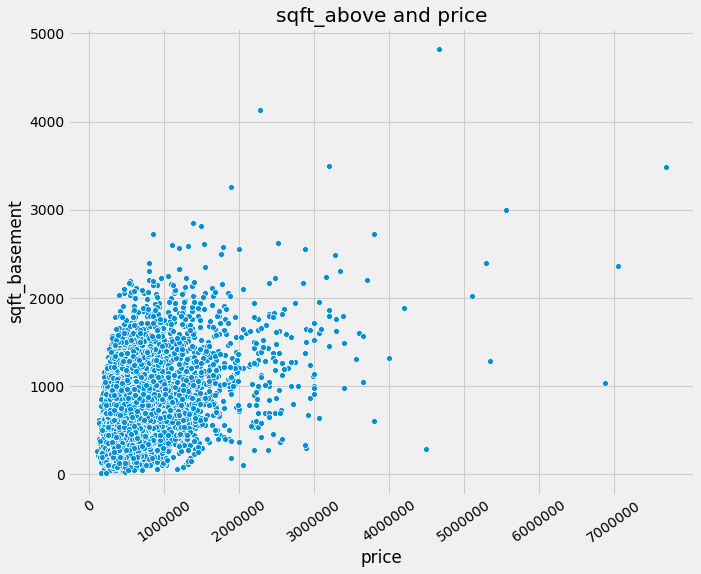

In [41]:
# посмотрю на другие признаки с площадью

sns.scatterplot(df[df['sqft_basement']>0]['price'], df[df['sqft_basement']>0]['sqft_basement'])

plt.title('sqft_above and price')
plt.xticks(np.arange(0, 8000000, 1000000), rotation=35);

In [42]:
# проверю корреляцию между площадью подвала (если есть) и цены

print('sqft above vs price correlation is {}'.format(df[df['sqft_basement']>0]['sqft_basement'].corr(df[df['sqft_basement']>0]['price'])))

sqft above vs price correlation is 0.40730824337795885


Попробую добавить бинарный признак наличия подвала.

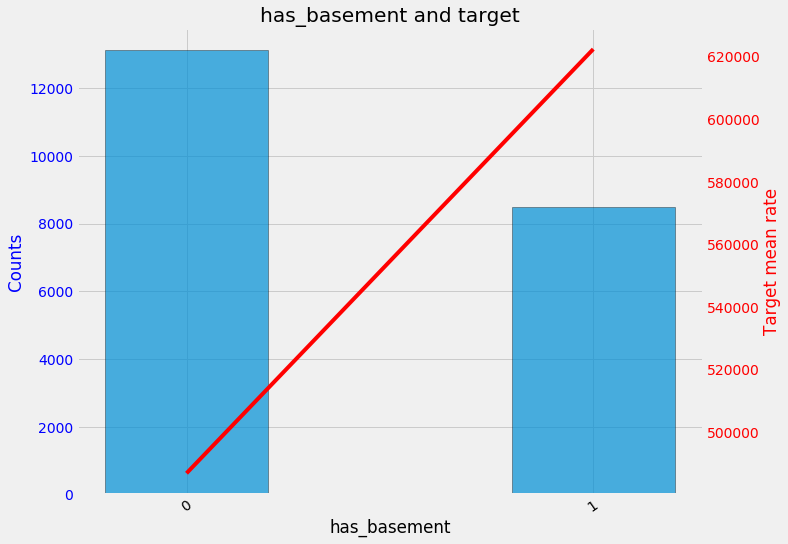

In [43]:
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x>0 else 0)

feature_stat(df, 'has_basement', 'price')

Кажется, признак неплохой, оставлю его.

In [44]:
# взгляну на оставшиеся признаки и их корелляцию

df[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15']].corr()

,sqft_living,sqft_lot,sqft_living15,sqft_lot15
sqft_living,1.000000,0.172826,0.756420,0.183286
sqft_lot,0.172826,1.000000,0.144608,0.718557
sqft_living15,0.756420,0.144608,1.000000,0.183192
sqft_lot15,0.183286,0.718557,0.183192,1.000000


Видно, что у нас есть скореллированные друг с другам признаки площади.  
Пожалуй, попробую сделать признак "была перепланировка" и удалю те, что с суффиксом 15.

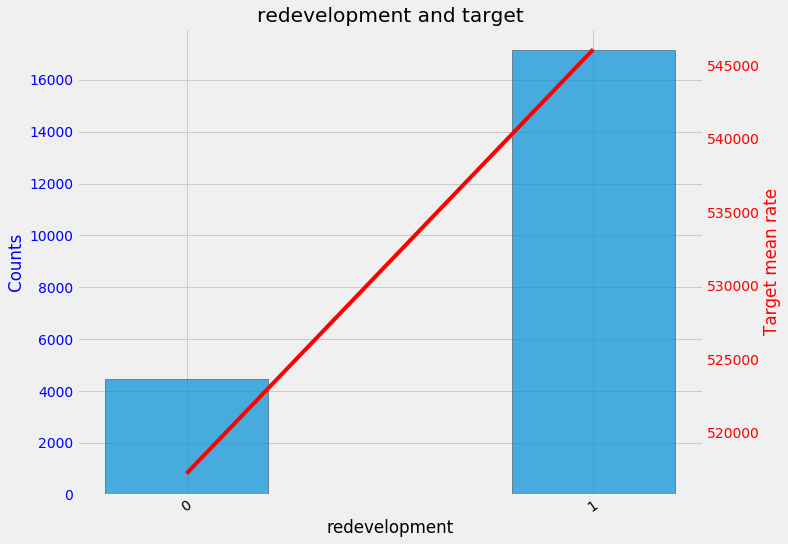

In [45]:
df['redevelopment'] = df['sqft_lot15'] - df['sqft_lot']
df['redevelopment'] = df['redevelopment'].apply(lambda x: 0 if x == 0 else 1)
df.drop(['sqft_lot15', 'sqft_living15'], axis=1, inplace=True)

feature_stat(df, 'redevelopment', 'price')

Признак тоже выглядит неплохо.  

Последними проанализирую временные признаки:

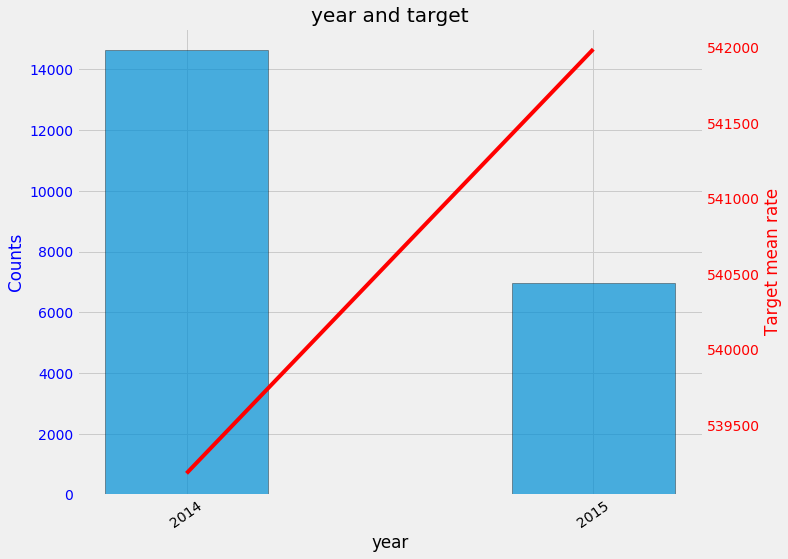

In [46]:
# приведу к дате

df['date'] = df['date'].apply(lambda x: x[:x.find('T')])
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d', errors='ignore')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# год объявления 

feature_stat(df, 'year', 'price')

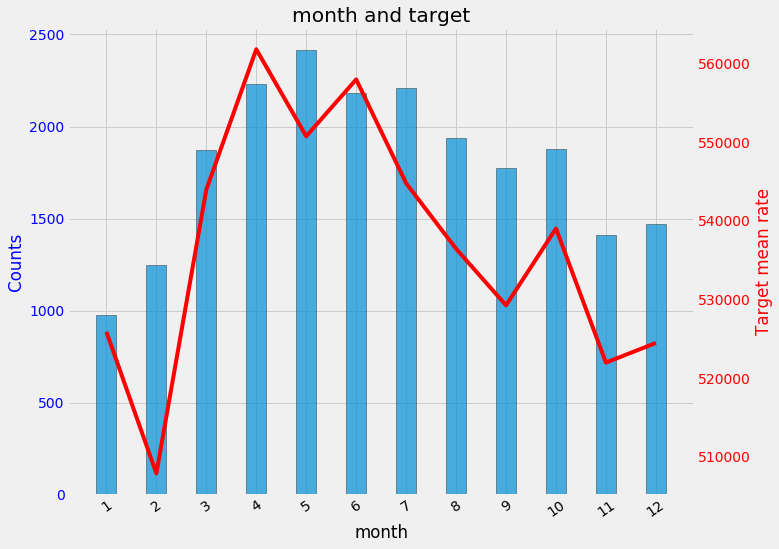

In [47]:
# месяц объявления

feature_stat(df, 'month', 'price')

Интересно, пик продаж и цен приходится на весну.

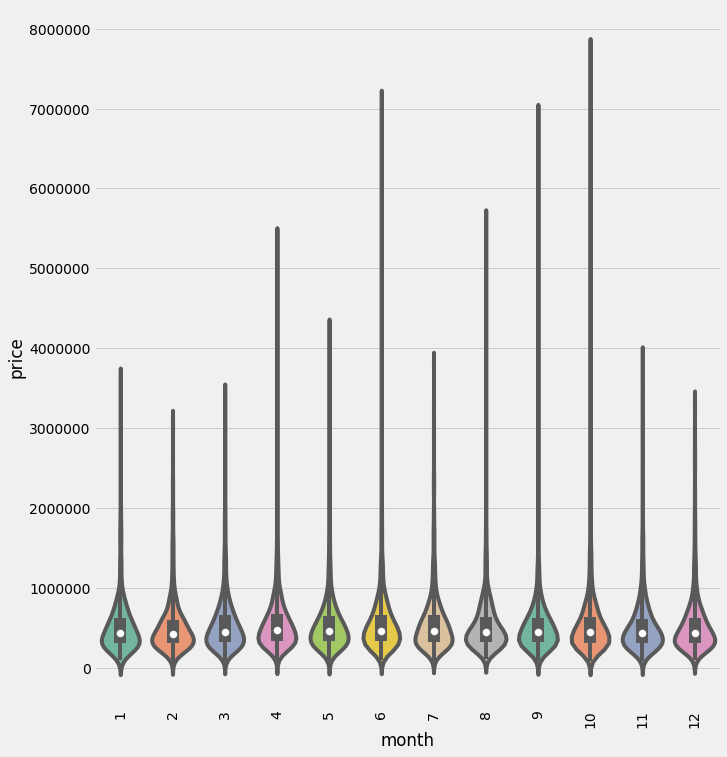

In [48]:
plt.figure(figsize=(10,12))
sns.violinplot(x='month', y='price', data=df, palette='Set2')
plt.xticks(rotation=90);

Менять ничего не буду, оставлю как есть. Первоначальный признак удалю:

In [49]:
df.drop('date', axis=1, inplace=True)

## Построение модели

### Подготовка данных для модели

In [50]:
# разделю датасет на таргет и признаки

df.set_index(keys='id', inplace=True)
X, y = df.drop(['price', 'log_price'], axis=1), df['log_price']

# воспроизводимость
rs = np.random.seed(0)

# разобью данные на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=rs)

# стандартизация данных

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Обучение моделей

Для начала обучу линейную регрессию, случайный лес и градиентный бустинг без подбора гиперпараметров.

In [51]:
def fit_evaluate_model(estimator, x_train, y_train, x_valid, y_valid):
    """
    Обучает регрессор и выводит метрику на валидации
    """
    model_name = str(estimator)
    model_name = model_name[:model_name.index('(')]
    estimator.fit(x_train, y_train)
    preds = estimator.predict(x_valid)
    valid_score = r2_score(y_valid, preds).round(4)
    
    print('{}\'s R2 score is: {}'.format(model_name, valid_score))
    
    return estimator


def get_feature_importance(model):
    """
    Выводит наиболее важные признаки
    """
    model_name = str(model)
    model_name = model_name[:model_name.index('(')]
    imp = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
    imp.sort_values('importance').plot(kind='barh', edgecolor='k')
    plt.title('{}\'s features importance'.format(model_name))
    plt.show()
    
    
# обучаю линейную регрессию
lr = fit_evaluate_model(LinearRegression(n_jobs=-1),
                        X_train, y_train, X_test, y_test)

# выведу топ коэффициентов
pd.DataFrame(lr.coef_, X.columns,
             columns=['coef']).sort_values(by='coef', ascending=False).head(10)


LinearRegression's R2 score is: 0.7964


,coef
renovation_diff,5.346714e+12
sqft_living,2.308681e+12
yr_built,3.825662e+11
lat,1.922605e-01
grade,1.759861e-01
decade_built,9.215116e-02
is_expensive,9.209710e-02
view,5.692126e-02
bathrooms,5.127552e-02
has_basement,4.546268e-02


RandomForestRegressor's R2 score is: 0.8768


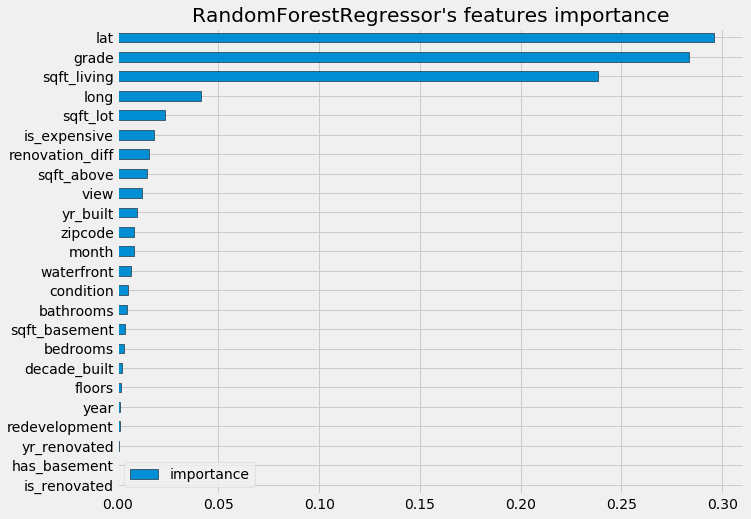

In [52]:
rf = fit_evaluate_model(RandomForestRegressor(random_state=rs, n_jobs=-1),
                        X_train, y_train, X_test, y_test)

get_feature_importance(rf)

LGBMRegressor's R2 score is: 0.904


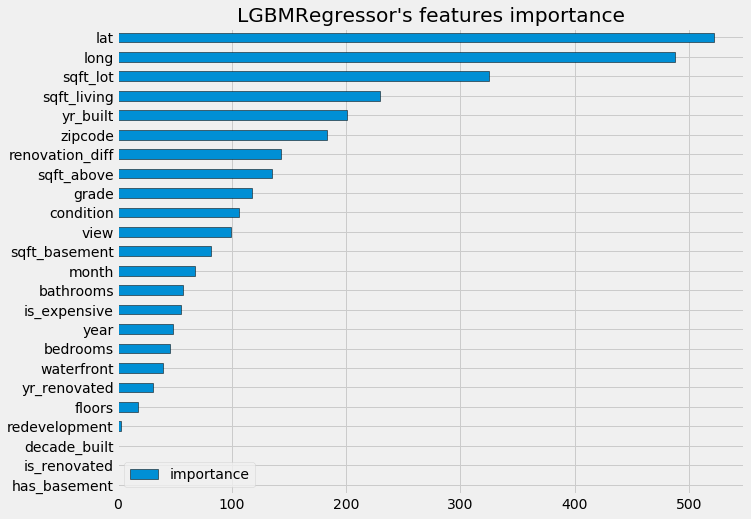

In [53]:
lgb = fit_evaluate_model(LGBMRegressor(random_state=rs, n_jobs=-1),
                         X_train, y_train, X_test, y_test)

get_feature_importance(lgb)

В целом, даже на стандартных настройках результат неплохой.  
Для повышения интерпретируемости результата переведу целевой признак обратно в доллары и оценю MAE и MAPE

In [54]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)))

# прогноз бустинга
preds = lgb.predict(X_test)

# привожу к первоначальному виду
y_test_dollars = np.exp(y_test)
preds_dollars = np.exp(preds)

print('MAPE for best model is {}'.format(mape(y_test_dollars, preds_dollars)))
print('================================================================')
print('MAE for best model is {}'.format(mae(y_test_dollars, preds_dollars)))

MAPE for best model is 11.856157315355325
MAE for best model is 63811.87095773966


Подберу параметры для LightGBM.  

Буду оптимизировать кол-во деревьев, глубину дерева, минимальное число объектов, число листьев.

In [55]:
lgbm_params = {
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_depth': [5, 10, 30, None],
    'min_data_in_leaf': [5, 10, 50, 100],
    'num_leaves': [100, 200, 500, 1000]
}


lgbm_grid = GridSearchCV(
    estimator=LGBMRegressor(),
    scoring='r2',
    param_grid=lgbm_params,
    cv=5,
    n_jobs=-1
)

lgbm_grid.fit(X_train, y_train)
lgbm = lgbm_grid.best_estimator_
preds = lgbm.predict(X_test)
print('LGBM\'s R2 score is: {}'.format(r2_score(y_test, preds)))

LGBM's R2 score is: 0.9073831847718588


Построю кривые обучения.

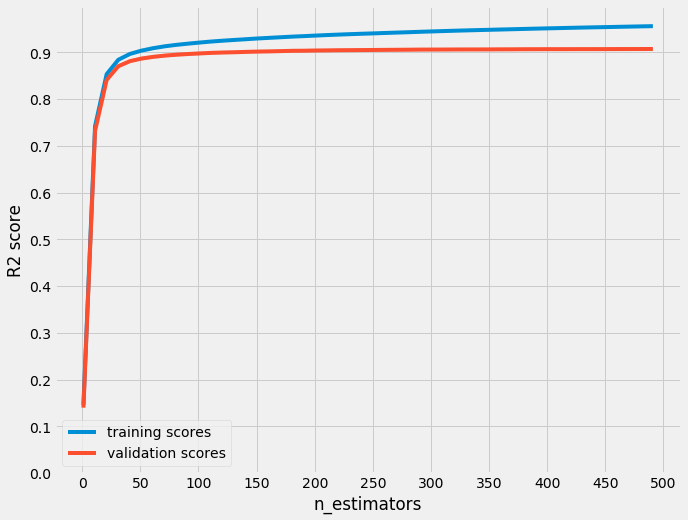

In [56]:
def plot_with_err(x, data, **kwargs):
    """
    Строит кривые валидации
    """
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
   

n_estimators = np.arange(1, 500, 10)
val_train, val_test = validation_curve(lgbm, X, y,
                                       'n_estimators', n_estimators, cv=5,
                                        scoring='r2')

plot_with_err(n_estimators, val_train, label='training scores')
plot_with_err(n_estimators, val_test, label='validation scores')
plt.xlabel('n_estimators'); plt.ylabel('R2 score')
plt.xticks(n_estimators)
plt.yticks(np.arange(0, 1, 0.1))
plt.xticks(np.arange(0, 501, 50))
plt.legend();

Результат ожидаемый, примерно со 100 деревьев R2 на валидации выходит на полку и дальше обучать особого смысла нет.  

В качестве финального штриха, оценю ошибки (MAE и MAPE) финальной модели:

In [57]:
# прогноз бустинга

preds = lgbm.predict(X_test)

# привожу к первоначальному виду
preds_dollars = np.exp(preds)

MAPE = mape(y_test_dollars, preds_dollars).round(2)
MAE = mae(y_test_dollars, preds_dollars).round(2)

print('MAPE for best model is {}'.format(MAPE))
print('=======================================')
print('MAE for best model is {}'.format(MAE))

MAPE for best model is 11.56
MAE for best model is 61586.77
